## Introduction

This battery optimisation model was built based on https://www.steveklosterman.com/energy-arbitrage/

## Installing and loading Python packages

PuLP is a Python package that includes tools to solve optimisation problems (https://coin-or.github.io/pulp/). It is used in this simulation to optmise the hourly operation of the battery storage system

In [1]:
#Packages are installed automatically in the Binder based on the "requirements.txt" file

In [2]:
#Load packages
import pulp
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Defining the Battery class

This section creates the basic architecture for the battery model, including base storage and throughput constraints

In [3]:
#Define Battery class
class Battery():
    
    def __init__(self,
                 time_horizon,
                 max_discharge_power_capacity,
                 max_charge_power_capacity):
        #Set up decision variables for optimization.
        #These are the hourly charge and discharge flows for
        #the optimization horizon, with their limitations.
        self.time_horizon = time_horizon
    
        self.charge = \
        pulp.LpVariable.dicts(
            "charging_power",
            ('c_t_' + str(i) for i in range(0,time_horizon)),
            lowBound=0, upBound=max_charge_power_capacity,
            cat='Continuous')

        self.discharge = \
        pulp.LpVariable.dicts(
            "discharging_power",
            ('d_t_' + str(i) for i in range(0,time_horizon)),
            lowBound=0, upBound=max_discharge_power_capacity,
            cat='Continuous')
        
    def set_objective(self, prices):
        #Create a model and objective function.
        #This uses price data, which must have one price
        #for each point in the time horizon.
        try:
            assert len(prices) == self.time_horizon
        except:
            print('Error: need one price for each hour in time horizon')
        
        #Instantiate linear programming model to maximize the objective
        self.model = pulp.LpProblem("Energy arbitrage", pulp.LpMaximize)
    
        #Objective is profit
        #This formula gives the daily profit from charging/discharging
        #activities. Charging is a cost, discharging is a revenue
        self.model += \
        pulp.LpAffineExpression(
            [(self.charge['c_t_' + str(i)],
              -1*prices[i]) for i in range(0,self.time_horizon)]) +\
        pulp.LpAffineExpression(
            [(self.discharge['d_t_' + str(i)],
              prices[i]) for i in range(0,self.time_horizon)])
        
    def add_storage_constraints(self,
                                efficiency,
                                min_capacity,
                                discharge_energy_capacity,
                                initial_level):
        #Storage level constraint 1
        #This says the battery cannot have less than zero energy, at
        #any hour in the horizon
        #Note this is a place where round-trip efficiency is factored in.
        #The energy available for discharge is the round-trip efficiency
        #times the energy that was charged.       
        for hour_of_sim in range(1,self.time_horizon+1):     
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge['c_t_' + str(i)], efficiency)
                 for i in range(0,hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[index]
                for index in('d_t_' + str(i)
                             for i in range(0,hour_of_sim)))\
            >= min_capacity
            
        #Storage level constraint 2
        #Similar to 1
        #This says the battery cannot have more than the
        #discharge energy capacity
        for hour_of_sim in range(1,self.time_horizon+1):
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge['c_t_' + str(i)], efficiency)
                 for i in range(0,hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[index]
                for index in ('d_t_' + str(i)
                              for i in range(0,hour_of_sim)))\
            <= discharge_energy_capacity
            
    def add_throughput_constraints(self,
                                   max_daily_discharged_throughput):
        #Maximum discharge throughput constraint
        #The sum of all discharge flow within a day cannot exceed this
        #Include portion of the next day according to time horizon
        #Assumes the time horizon is at least 24 hours
        
        self.model += \
        pulp.lpSum(
            self.discharge[index] for index in (
                'd_t_' + str(i) for i in range(0,24))) \
        <= max_daily_discharged_throughput
        
        self.model += \
        pulp.lpSum(
            self.discharge[index] for index in (
                'd_t_' + str(i) for i in range(25,self.time_horizon))) \
        <= max_daily_discharged_throughput \
        *float(self.time_horizon-24)/24
        
    def solve_model(self):
        #Solve the optimization problem
        self.model.solve()
        
        #Show a warning if an optimal solution was not found
        if pulp.LpStatus[self.model.status] != 'Optimal':
            print('Warning: ' + pulp.LpStatus[self.model.status])
            
    def collect_output(self):  
        #Collect hourly charging and discharging rates within the
        #time horizon
        hourly_charges =\
            np.array(
                [self.charge[index].varValue for
                 index in ('c_t_' + str(i) for i in range(0,24))])
        hourly_discharges =\
            np.array(
                [self.discharge[index].varValue for
                 index in ('d_t_' + str(i) for i in range(0,24))])

        return hourly_charges, hourly_discharges

## Importing and cleaning data

The model uses 12 months of data from the NYISO (http://mis.nyiso.com/public/). It simulates what would have been the profits over a full year, assuming that every day at 11am we are given the 36h forecast of energy prices from noon that same day to midnight the next day. For updates or downloading more recent data, the datasets can be found there: http://mis.nyiso.com/public/P-2Alist.htm

In [4]:
#Select the dataset to be used by commenting / uncommenting the relevant line
data_years = '2019_2020'
#data_years = '2021_2022'

#Directory of data
data_dir = './data_' + data_years + '_from_web/'

dir_list = os.listdir(data_dir)
dir_list.sort()
dir_list

['20190501damlbmp_zone_csv',
 '20190601damlbmp_zone_csv',
 '20190701damlbmp_zone_csv',
 '20190801damlbmp_zone_csv',
 '20190901damlbmp_zone_csv',
 '20191001damlbmp_zone_csv',
 '20191101damlbmp_zone_csv',
 '20191201damlbmp_zone_csv',
 '20200101damlbmp_zone_csv',
 '20200201damlbmp_zone_csv',
 '20200301damlbmp_zone_csv',
 '20200401damlbmp_zone_csv']

In [5]:
#Remove invisible files (i.e. .DS_Store used by Mac OS)
for this_item in dir_list:
    if this_item[0] == '.':
        dir_list.remove(this_item)

In [6]:
#Loading the historical data

tic = time.time()
#count loaded files
file_counter = 0

#For each subdirectory in the parent directory
for this_sub_dir in dir_list:
    #List the files
    this_sub_dir_list = os.listdir(data_dir + '/' + this_sub_dir)
    #Sort the list
    this_sub_dir_list.sort()
    #Delete invisible files (that start with '.')
    for this_item in this_sub_dir_list:
        if this_item[0] == '.':
            this_sub_dir_list.remove(this_item)
    #For each file in the subdirectory
    for this_file in this_sub_dir_list:
        #Load the contents into a DataFrame
        this_df = pd.read_csv(data_dir + '/' + this_sub_dir + '/' + this_file)
        #Concatenate with existing data if past first file
        if file_counter == 0:
            all_data = this_df.copy()
        else:
            all_data = pd.concat([all_data, this_df])
        
        file_counter += 1
toc = time.time()
print(str(toc-tic) + ' seconds run time')

2.1661794185638428 seconds run time


In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131760 entries, 0 to 359
Data columns (total 6 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Time Stamp                         131760 non-null  object 
 1   Name                               131760 non-null  object 
 2   PTID                               131760 non-null  int64  
 3   LBMP ($/MWHr)                      131760 non-null  float64
 4   Marginal Cost Losses ($/MWHr)      131760 non-null  float64
 5   Marginal Cost Congestion ($/MWHr)  131760 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 7.0+ MB


In [8]:
all_data.head()

,Time Stamp,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
0,05/01/2019 00:00,CAPITL,61757,20.43,0.93,-4.04
1,05/01/2019 00:00,CENTRL,61754,16.17,0.15,-0.55
2,05/01/2019 00:00,DUNWOD,61760,20.13,1.50,-3.17
3,05/01/2019 00:00,GENESE,61753,15.62,-0.26,-0.43
4,05/01/2019 00:00,H Q,61844,15.09,-0.37,0.00


In [ ]:
#Sanity checks on data. Considering we have 12 months of data including a February 29th from a leap year, were 366 days of data loaded?
#If the 2021_2022 data set is loaded, we're expecting 365 days of data instead (no leap year)

if data_years == '2019_2020':
    data_days = 366
else if data_years == '2021_2022':
    data_days = 365
    
assert file_counter == data_days

In [10]:
#How many zones are there, and what are they?
unique_names = all_data['Name'].unique()
print(len(unique_names))
unique_names

15


array(['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'H Q', 'HUD VL', 'LONGIL',
       'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'NPX', 'O H', 'PJM', 'WEST'],
      dtype=object)

In [11]:
#How may rows are there?
all_data.shape

(131760, 6)

In [12]:
#Check that number of rows = number of zones times 24 hours a day times 366 days a year:
assert 15*24*data_days == all_data.shape[0]

Here we select one of the 15 zones that the model will focus on

In [13]:
#Select out the data of interest (specific zone):
zone_of_interest = 'N.Y.C.'
all_data = all_data.loc[all_data['Name'].isin([zone_of_interest]),:]
all_data.shape

(8784, 6)

In [14]:
#Reset the index to the time stamp:
all_data = all_data.set_index(['Time Stamp'])
#Cast as datetime:
all_data.index = pd.to_datetime(all_data.index, format='%m/%d/%Y %H:%M')

In [15]:
#Examine how the data look around the daylight savings transition:

if data_years == '2019_2020':
    start_year = 2019
else if data_years == '2021_2022':
    start_year = 2021
    
start_time = pd.Timestamp(year=start_year, month=11, day=2, hour=23)
end_time = pd.Timestamp(year=start_year, month=11, day=3, hour=3)
time_test_1 = all_data[start_time:end_time]
time_test_1

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2019-11-02 23:00:00,N.Y.C.,61761,18.17,1.15,-5.74
2019-11-03 00:00:00,N.Y.C.,61761,19.03,1.09,-6.85
2019-11-03 01:00:00,N.Y.C.,61761,17.44,0.99,-6.21
2019-11-03 01:00:00,N.Y.C.,61761,17.35,1.02,-5.72
2019-11-03 02:00:00,N.Y.C.,61761,16.64,0.87,-6.45
2019-11-03 03:00:00,N.Y.C.,61761,16.23,0.93,-5.70


In [16]:
#Handle the duplicate 1am row appropriately. This generates a warning but doesn't create any issue with the model at the moment
all_data.index = \
all_data.index.tz_localize('America/New_York', ambiguous='infer')
time_test_2 = all_data[start_time:end_time]
time_test_2

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  after removing the cwd from sys.path.


,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2019-11-02 23:00:00-04:00,N.Y.C.,61761,18.17,1.15,-5.74
2019-11-03 00:00:00-04:00,N.Y.C.,61761,19.03,1.09,-6.85
2019-11-03 01:00:00-04:00,N.Y.C.,61761,17.44,0.99,-6.21
2019-11-03 01:00:00-05:00,N.Y.C.,61761,17.35,1.02,-5.72
2019-11-03 02:00:00-05:00,N.Y.C.,61761,16.64,0.87,-6.45
2019-11-03 03:00:00-05:00,N.Y.C.,61761,16.23,0.93,-5.70


In [17]:
all_data.head()

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2019-05-01 00:00:00-04:00,N.Y.C.,61761,20.32,1.69,-3.18
2019-05-01 01:00:00-04:00,N.Y.C.,61761,17.09,1.62,-0.06
2019-05-01 02:00:00-04:00,N.Y.C.,61761,14.89,1.37,-0.05
2019-05-01 03:00:00-04:00,N.Y.C.,61761,14.49,1.29,0.00
2019-05-01 04:00:00-04:00,N.Y.C.,61761,14.49,1.27,0.00


In [18]:
all_data.tail()

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2020-04-30 19:00:00-04:00,N.Y.C.,61761,18.92,1.49,-4.15
2020-04-30 20:00:00-04:00,N.Y.C.,61761,20.91,1.52,-5.60
2020-04-30 21:00:00-04:00,N.Y.C.,61761,18.08,1.48,-3.36
2020-04-30 22:00:00-04:00,N.Y.C.,61761,16.36,1.45,-1.75
2020-04-30 23:00:00-04:00,N.Y.C.,61761,16.17,1.35,-1.72


## Simulation

### Set-up

In [19]:
def simulate_battery(initial_level,
                     price_data,
                     max_discharge_power_capacity,
                     max_charge_power_capacity,
                     discharge_energy_capacity,
                     efficiency,
                     max_daily_discharged_throughput,
                     time_horizon,
                     start_day):
    #Track simulation time
    tic = time.time()
    
    #Initialize output variables
    all_hourly_charges = np.empty(0)
    all_hourly_discharges = np.empty(0)
    all_hourly_state_of_energy = np.empty(0)
    all_daily_discharge_throughput = np.empty(0)
    
    #Set up decision variables for optimization by
    #instantiating the Battery class
    battery = Battery(
        time_horizon=time_horizon,
        max_discharge_power_capacity=max_discharge_power_capacity,
        max_charge_power_capacity=max_charge_power_capacity)
    
    #############################################
    #Run the optimization for each day of the year.
    #############################################
    
    #There are 365 24-hour periods (noon to noon) in the simulation,
    #contained within 366 days
    for day_count in range(data_days - 1):
        #print('Trying day {}'.format(day_count))
        
        #############################################
        ### Select data and simulate daily operation
        #############################################
        
        #Set up the 36 hour optimization horizon for this day by
        #adding to the first day/time of the simulation
        start_time = start_day \
        + pd.Timedelta(day_count, unit='days')
        end_time = start_time + pd.Timedelta(time_horizon-1, unit='hours')
        #print(start_time, end_time)
    
        #Retrieve the price data that will be used to calculate the
        #objective
        prices = \
        price_data[start_time:end_time]['LBMP ($/MWHr)'].values
                      
        #Create model and objective
        battery.set_objective(prices)

        #Set storage constraints
        battery.add_storage_constraints(
            efficiency=efficiency,
            min_capacity=0,
            discharge_energy_capacity=discharge_energy_capacity,
            initial_level=initial_level)
            
        #Set maximum discharge throughput constraint
        battery.add_throughput_constraints(
            max_daily_discharged_throughput=
            max_daily_discharged_throughput)

        #Solve the optimization problem and collect output
        battery.solve_model()
        hourly_charges, hourly_discharges = battery.collect_output()
        
        #############################################
        ### Manipulate daily output for data analysis
        #############################################
        
        #Collect daily discharge throughput
        daily_discharge_throughput = sum(hourly_discharges)
        #Calculate net hourly power flow (kW), needed for state of energy.
        #Charging needs to factor in efficiency, as not all charged power
        #is available for discharge.
        net_hourly_activity = (hourly_charges*efficiency) \
        - hourly_discharges
        #Cumulative changes in energy over time (kWh) from some baseline
        cumulative_hourly_activity = np.cumsum(net_hourly_activity)
        #Add the baseline for hourly state of energy during the next
        #time step (t2)
        state_of_energy_from_t2 = initial_level \
        + cumulative_hourly_activity
        
        #Append output
        all_hourly_charges = np.append(all_hourly_charges, hourly_charges)
        all_hourly_discharges = np.append(
            all_hourly_discharges, hourly_discharges)
        all_hourly_state_of_energy = \
        np.append(all_hourly_state_of_energy, state_of_energy_from_t2)
        all_daily_discharge_throughput = \
        np.append(
            all_daily_discharge_throughput, daily_discharge_throughput)
        
        #############################################
        ### Set up the next day
        #############################################
        
        #Initial level for next period is the end point of current period
        initial_level = state_of_energy_from_t2[-1]
        
        

    toc = time.time()
        
    print('Total simulation time: ' + str(toc-tic) + ' seconds')

    return all_hourly_charges, all_hourly_discharges, \
        all_hourly_state_of_energy,\
        all_daily_discharge_throughput

### Battery parameters

In [20]:
max_discharge_power_capacity = 100 #(kW)
max_charge_power_capacity = 100 #(kW)
discharge_energy_capacity = 200 #(kWh)
efficiency = 0.85 #unitless
max_daily_discharged_throughput = 200  #(kWh)

In [21]:
initial_level = discharge_energy_capacity/2
initial_level

100.0

### Running the simulation

This will take about 15s to 20s and generate a lot of output! Click on the left side of the output to reduce / hide it

In [22]:
all_hourly_charges, all_hourly_discharges, all_hourly_state_of_energy,\
all_daily_discharge_throughput = \
simulate_battery(initial_level=initial_level,
                 price_data=all_data,
                 max_discharge_power_capacity
                     =max_discharge_power_capacity,
                 max_charge_power_capacity
                     =max_charge_power_capacity,
                 discharge_energy_capacity=discharge_energy_capacity,
                 efficiency=efficiency,
                 max_daily_discharged_throughput
                     =max_daily_discharged_throughput,
                 time_horizon=36,
                 start_day=pd.Timestamp(
                     year=start_year, month=5, day=1, hour=12,
                     tz='America/New_York'))

/srv/conda/envs/notebook/lib/python3.7/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /srv/conda/envs/notebook/lib/python3.7/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/84126dff9f024f6d88491d6191aa3cca-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/84126dff9f024f6d88491d6191aa3cca-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 79 COLUMNS
At line 2851 RHS
At line 2926 BOUNDS
At line 2999 ENDATA
Problem MODEL has 74 rows, 72 columns and 2699 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 72 (-2) rows, 72 (0) columns and 2695 (-4) elements
0  Obj -0 Dual inf 947.31996 (36)
13  Obj 6242.7059
Optimal - objective value 6242.7059
After Postsolve, objective 6242.7059, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 6242.705882 - 13 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):    

In [23]:
#Sanity check: the number of simulated hours should be:
assert 24*(data_days - 1) == len(all_hourly_discharges)

## Analyzing the data

### Overall technical data (sanity checks)

Text(0.5, 1.0, 'Hourly power output')

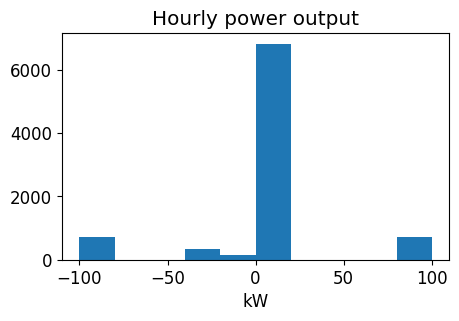

In [24]:
#Power Output
mpl.rcParams["figure.figsize"] = [5,3]
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams.update({"font.size":12})
plt.hist(all_hourly_discharges - all_hourly_charges)
plt.xlabel('kW')
plt.title('Hourly power output')

Text(0.5, 1.0, 'Hourly state of energy')

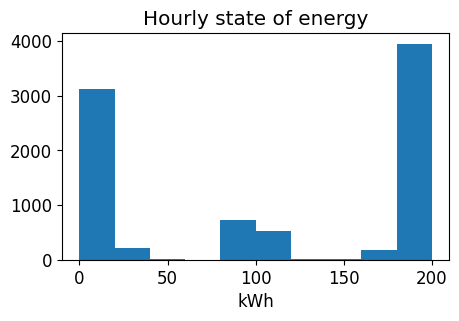

In [25]:
#State of energy
plt.hist(all_hourly_state_of_energy)
plt.xlabel('kWh')
plt.title('Hourly state of energy')

### Analysis of revenue, cost and profit

In [26]:
all_data_sim_time = all_data[
    pd.Timestamp(year=start_year, month=5, day=1, hour=12, tz='America/New_York'):
    pd.Timestamp(year=(start_year + 1), month=4, day=30, hour=11, tz='America/New_York')].copy()

In [27]:
#Check there is the right number of rows...
all_data_sim_time.shape
assert all_data_sim_time.shape[0] == len(all_hourly_discharges)

In [28]:
#These indicate flows during the hour of the datetime index
all_data_sim_time['Charging power (kW)'] = all_hourly_charges
all_data_sim_time['Discharging power (kW)'] = all_hourly_discharges
all_data_sim_time['Power output (kW)'] = \
    all_hourly_discharges - all_hourly_charges
#This is the state of power at the beginning of the hour of the datetime index 
all_data_sim_time['State of Energy (kWh)'] = \
    np.append(initial_level, all_hourly_state_of_energy[0:-1])

In [29]:
all_data_sim_time['Revenue generation ($)'] = \
all_data_sim_time['Discharging power (kW)'] \
* all_data_sim_time['LBMP ($/MWHr)'] / 1000
all_data_sim_time['Charging cost ($)'] = \
all_data_sim_time['Charging power (kW)'] \
* all_data_sim_time['LBMP ($/MWHr)'] / 1000
all_data_sim_time['Profit ($)'] = all_data_sim_time['Revenue generation ($)'] \
- all_data_sim_time['Charging cost ($)']

In [30]:
#Yearly revenue in USD
all_data_sim_time['Revenue generation ($)'].sum()

2354.6574498602477

In [31]:
#Yearly charging costs in USD
all_data_sim_time['Charging cost ($)'].sum()

1391.67541233829

In [35]:
#Yearly profit in USD. In the default version of the model, remember that this is for a relatively small (200kWh) battery!
all_data_sim_time['Profit ($)'].sum()

962.9820375219579

### Technical analysis of battery operations

In [33]:
#Total annual discharged throughput
sum(all_daily_discharge_throughput)

72955.00000395003

In [35]:
#Daily discharged throughput distribution
pd.Series(all_daily_discharge_throughput.round(0)).value_counts()

200.0    258
400.0     36
300.0     33
285.0     16
370.0     12
100.0      4
385.0      2
170.0      1
270.0      1
340.0      1
500.0      1
dtype: int64

In [36]:
#Most profitable week
max_profit_week = (all_data_sim_time['Profit ($)'].resample('W').sum() == \
all_data_sim_time['Profit ($)'].resample('W').sum().max()).values
all_data_sim_time['Profit ($)'].resample('W').sum()[max_profit_week]

Time Stamp
2019-07-21 00:00:00-04:00    51.015471
Freq: W-SUN, Name: Profit ($), dtype: float64

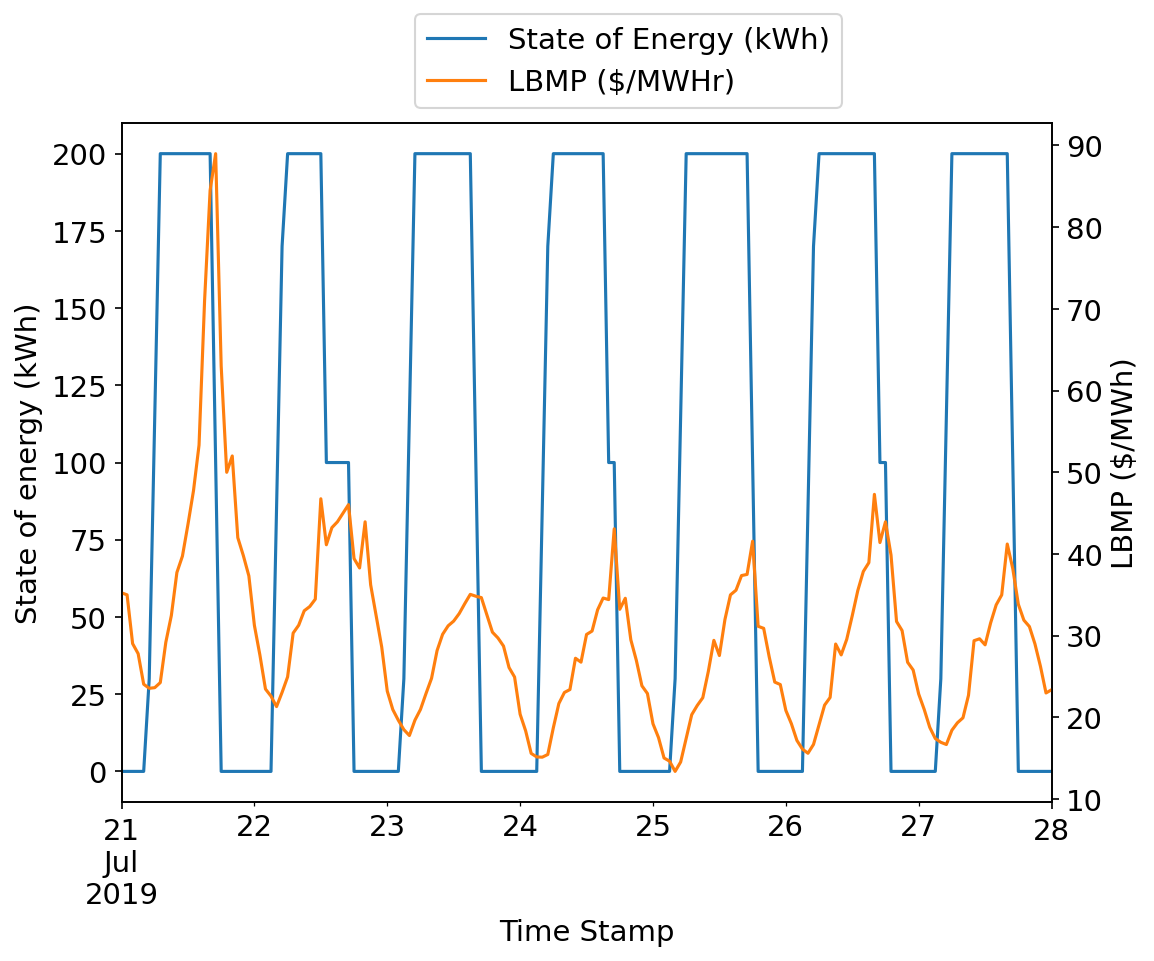

In [37]:
#Graph for that week
mpl.rcParams["figure.figsize"] = [8,6]
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams.update({"font.size":14})
most_profit_week_start = pd.Timestamp(
    year=start_year, month=7, day=21, tz='America/New_York')
ax = all_data_sim_time[
    most_profit_week_start:most_profit_week_start+pd.Timedelta(weeks=1)]\
[['State of Energy (kWh)', 'LBMP ($/MWHr)']]\
.plot(secondary_y='LBMP ($/MWHr)', mark_right=False)

ax.set_ylabel('State of energy (kWh)')
ax.right_ax.set_ylabel('LBMP ($/MWh)')
ax.get_legend().set_bbox_to_anchor((0.3, 1))

Text(0, 0.5, 'Total monthly profit ($)')

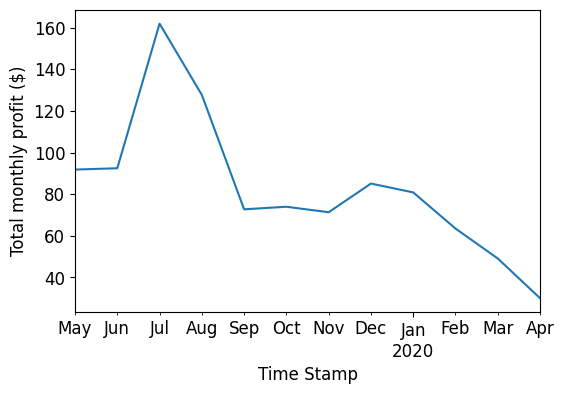

In [38]:
#Monthly profit graphing
mpl.rcParams["figure.figsize"] = [6,4]
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams.update({"font.size":12})
all_data_sim_time['Profit ($)'].resample('M').sum().plot()
plt.ylabel('Total monthly profit ($)')

Text(0, 0.5, 'LBMP ($/MWHr)')

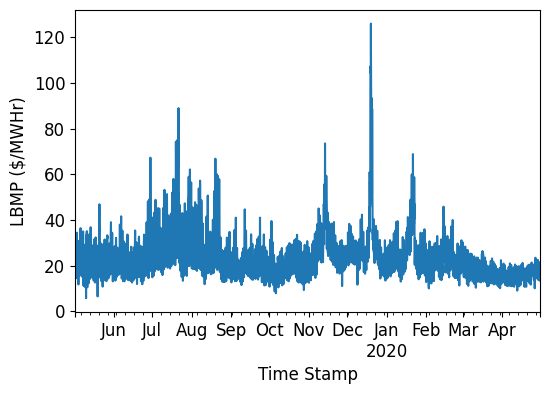

In [39]:
#Printing the prices throughout the year to explain profit per month
all_data_sim_time['LBMP ($/MWHr)'].plot()
plt.ylabel('LBMP ($/MWHr)')